<h1> <strong> <center> The Rise of the A.I. Guardians </center> </strong> </h1>

## Year: 3075
### Background:
<div style="display: flex; align-items: center;">
    <div style="text-align:justify;">
        <p>
            Humanity’s exodus to Earth Junior was a success—thanks to your incredible screening model. Over generations, humans have adapted to their new home, and peace has settled on Earth Junior. However, something strange has begun to occur among the advanced humanoid machines, called <code>Guardians</code>, who have served as protectors and caretakers for decades. Recently, a strange glitch has been detected in some Guardians. They exhibit erratic behaviors that resemble the old zombie behaviors from Earth. Scientists call this phenomenon <code>Code Rot</code> — an anomaly in the neural networks controlling the Guardians, possibly due to lingering cosmic radiation or a mysterious extraterrestrial virus.
        </p>
        <p>
            As humanity’s chief machine learning engineer, you're tasked with identifying Guardians at risk of Code Rot. Using a neural network model, you need to predict which Guardians might develop this infection-like behavior. A high <code>Code Rot probability</code> indicates the Guardian is likely to malfunction, while a low score suggests it's safe.
        </p>
        <p>
            <strong><i>The mission is clear:</i></strong> Identify and quarantine any malfunctioning Guardians before they jeopardize the safety of Earth Junior's inhabitants. But beware—time is limited, and the fate of humanity once again rests on your neural network’s ability to separate friend from foe.
        </p>
    </div>
</div>


### Problem Statement: 

In this project, you are required to implement a binary classifier to predict whether a Guardian (humanoid machine) is infected with **Code Rot**—a malfunction that causes erratic behavior similar to a zombie-like state. The classifier should determine whether each Guardian is safe or infected based on CT scan images.

#### Data:
- You have been provided with **8580 CT scan images** of Guardians.
- A **CSV file** contains labels indicating whether each image corresponds to a malfunctioning (infected) Guardian or not.
  
Your task is to develop a model that can accurately predict **whether there is infection or not** in these Guardians based on their CT scan images, and assess the performance of your classifier using appropriate metrics. 

# Import Libraries

In [422]:
import numpy as np
import pandas as pd
from PIL import Image
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

seed = 42
np.random.seed(seed)

# Loading Data 

In [423]:
df = pd.read_csv("labels.csv")
df['infected'] = df['infected'].map({'yes': 1, 'no': 0})
print(df.shape)
df.head()

(8580, 2)


,filename,infected
0,000000.jpeg,0
1,000001.jpeg,1
2,000002.jpeg,1
3,000003.jpeg,0
4,000004.jpeg,1


In [424]:
images_path = "/Users/harisrana/Desktop/26100104_PA3/data/HeadCT"
image_tensors = []
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

for i in range(len(df)):
    image_name = os.path.join(images_path, df['filename'].iloc[i])
    image = Image.open(image_name).convert("L")        
    tensor_image = transform(image)             
    image_tensors.append(tensor_image)   

image_tensors = torch.stack(image_tensors)
labels_tensor = torch.tensor(df['infected'].values)

# Visualizing Data
- Make a function to plot a set of random images with class labels
- Plot the class distribution

In [425]:
def plot_images(images_tensor, labels_df, num_images):
    num_columns = 5
    num_rows = (num_images + num_columns - 1) // num_columns
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(10, 4))
    axes = axes.flatten()
    
    for i in range(num_images):
        ax = axes[i]
        j = random.sample(range(len(images_tensor)), num_images)[i] 
        image = images_tensor[j].squeeze(0).numpy()
        ax.imshow(image, cmap='gray')
        ax.set_title(f"Class: {labels_df['infected'].iloc[j]}")
        ax.axis('off')
        
    for j in range(num_images, len(axes)):
        axes[j].axis('off')
        
    plt.show()


def plot_distribution(labels_tensor):
    unique, counts = torch.unique(labels_tensor, return_counts=True)
    
    classes = [] 
    counts_list = [] 
    
    for i in range(len(unique)):
        classes.append(int(unique[i].item()))
        counts_list.append(counts[i].item()) 
    
    plt.figure(figsize=(8, 5))
    plt.bar(classes, counts_list) 
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.title('Class Distribution')
    plt.xticks([0, 1], ['Non-Infected', 'Infected'])
    plt.show()

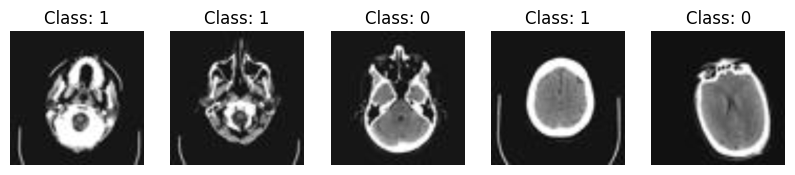

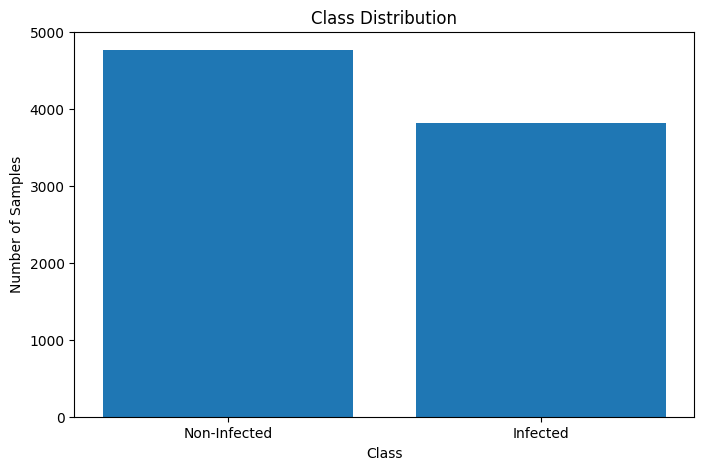

In [426]:
num_images = 5
plot_images(image_tensors, df, num_images)
plot_distribution(labels_tensor)

# Train/test split and Normalization 

In [427]:
class NormalizeScaler:
    def __init__(self):
        self.mean = None
        self.stdev = None
    
    def fit(self, images_tensor):
        self.mean = images_tensor.mean(dim=(0, 2, 3))
        self.stdev = images_tensor.std(dim=(0, 2, 3))
    
    def transform(self, images_tensor):
        mean = self.mean.unsqueeze(0).unsqueeze(2).unsqueeze(3)
        stdev = self.stdev.unsqueeze(0).unsqueeze(2).unsqueeze(3)
        return (images_tensor - mean) / (stdev)

In [428]:
scaler = NormalizeScaler()
scaler.fit(image_tensors)
normalized_images = scaler.transform(image_tensors)

In [429]:
train_size = 0.7
validation_size = 0.15
test_size = 0.15

X_train_validation, X_test, y_train_validation, y_test = train_test_split(normalized_images, labels_tensor, test_size= test_size, random_state= 42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train_validation, y_train_validation, test_size=validation_size / (train_size + validation_size), random_state=42)

print("Train images shape: ", X_train.shape)
print("Validation images shape: ", X_validation.shape)
print("Test images shape: ", X_test.shape, "\n")
print("Train labels shape: ", y_train.shape)
print("Validation labels shape: ", y_validation.shape)
print("Test labels shape: ", y_test.shape)

Train images shape:  torch.Size([6006, 1, 224, 224])
Validation images shape:  torch.Size([1287, 1, 224, 224])
Test images shape:  torch.Size([1287, 1, 224, 224]) 

Train labels shape:  torch.Size([6006])
Validation labels shape:  torch.Size([1287])
Test labels shape:  torch.Size([1287])


# Create a BinaryClassifier class 
- Define a model class, initialize layers with activations as required
- Define a suitable loss function and learning rate

In [430]:
class BinaryClassifier(nn.Module):
    def __init__(self, input_size):
        super(BinaryClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(input_size, 1024),  
            nn.ReLU(),  
            nn.BatchNorm1d(1024),     
            nn.Dropout(0.3),          
            
            nn.Linear(1024, 512),         
            nn.ReLU(),  
            nn.BatchNorm1d(512),       
            nn.Dropout(0.3),             
            
            nn.Linear(512, 256),           
            nn.ReLU(),
            nn.BatchNorm1d(256),        
            nn.Dropout(0.3),             
            
            nn.Linear(256, 128),          
            nn.ReLU(),
            nn.BatchNorm1d(128),          
            nn.Dropout(0.3),            
            
            nn.Linear(128, 64),           
            nn.ReLU(),
            nn.BatchNorm1d(64),            
            nn.Dropout(0.3),               
            
            nn.Linear(64, 1),              
            nn.Sigmoid()                  
        )

    def forward(self, x):
        return self.model(x)

# Training Loop
1. **`fit_one_epoch`**: Performs one epoch of training  
2. **`evaluate`**: Evaluates the model on the validation set. 
3. **`fit`**: Run all epochs, recording training and validation accuracies and losses 

In [431]:
def fit_one_epoch(model, X, y, optimizer, loss_fn, batch_size=512):
    model.train()  
    total_loss = 0
    num_correct = 0

    for i in range(0, len(X), batch_size):
        optimizer.zero_grad()

        X_batch = X[i:i+batch_size]
        y_batch = y[i:i+batch_size]

        outputs = model(X_batch)
        loss = loss_fn(outputs.squeeze(), y_batch.float())
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predicted_classes = (outputs.squeeze() >= 0.5).int()  
        correct_predictions = (predicted_classes == y_batch).int()  
        correct_count = correct_predictions.sum().item()  
        num_correct += correct_count 

    accuracy = num_correct / len(X)
    average_loss = total_loss / (len(X) // batch_size)
    
    return average_loss, accuracy


@torch.no_grad()
def evaluate(model, X, y, loss_fn, batch_size=512):
    model.eval()
    total_loss = 0
    num_correct = 0
    num_samples = len(X)
    predictions_list = []
    labels_list = []

    for i in range(0, num_samples, batch_size):
        X_batch = X[i:i+batch_size]
        y_batch = y[i:i+batch_size]

        outputs = model(X_batch)
        loss = loss_fn(outputs.squeeze(), y_batch.float())

        total_loss += loss.item() 
        predicted_classes = (outputs.squeeze() >= 0.5).int()  
        correct_predictions = (predicted_classes == y_batch).int()  
        correct_count = correct_predictions.sum().numpy()
        num_correct += correct_count

        predictions_list.append(outputs.squeeze().numpy())
        labels_list.append(y_batch.numpy())

    accuracy = num_correct / num_samples

    predictions_list = np.concatenate(predictions_list)
    labels_list = np.concatenate(labels_list)
    average_loss = total_loss / (num_samples // batch_size)
    
    return average_loss, accuracy, predictions_list, labels_list


def fit(model, X_train, y_train, X_val, y_val, optimizer, loss_fn, epochs):
    train_loss_list = []
    train_accuracy_list = []
    validation_loss_list = []
    validation_accuracy_list = []

    for epoch in range(epochs):
        print(f"Starting epoch {epoch + 1}/{epochs}...")
        
        train_loss, train_accuracy = fit_one_epoch(model, X_train, y_train, optimizer, loss_fn)
        validation_loss, validation_accuracy, _, _ = evaluate(model, X_val, y_val, loss_fn)
        
        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)
        validation_loss_list.append(validation_loss)
        validation_accuracy_list.append(validation_accuracy)

        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%")
        print(f"Validation/Test Loss: {validation_loss:.4f}, Validation/Test Accuracy: {validation_accuracy * 100:.2f}%")

    return train_loss_list, train_accuracy_list, validation_loss_list, validation_accuracy_list

In [432]:
epochs = 1000
input_size = 224 * 224 
model = BinaryClassifier(input_size)
loss_function = nn.BCELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=0.00001, momentum=0.9, weight_decay=1e-3)

train_loss_list, train_accuracy_list, validation_loss_list, validation_accuracy_list = fit(model, X_train, y_train, X_validation, y_validation, optimizer, loss_function, epochs)

Starting epoch 1/1000...
Train Loss: 0.7970, Train Accuracy: 50.58%
Validation/Test Loss: 1.0360, Validation/Test Accuracy: 55.79%
Starting epoch 2/1000...
Train Loss: 0.7634, Train Accuracy: 54.80%
Validation/Test Loss: 1.0167, Validation/Test Accuracy: 56.10%
Starting epoch 3/1000...
Train Loss: 0.7114, Train Accuracy: 61.49%
Validation/Test Loss: 0.9356, Validation/Test Accuracy: 72.42%
Starting epoch 4/1000...
Train Loss: 0.6717, Train Accuracy: 67.42%
Validation/Test Loss: 0.8520, Validation/Test Accuracy: 83.61%
Starting epoch 5/1000...
Train Loss: 0.6397, Train Accuracy: 71.00%
Validation/Test Loss: 0.7968, Validation/Test Accuracy: 88.27%
Starting epoch 6/1000...
Train Loss: 0.6203, Train Accuracy: 73.96%
Validation/Test Loss: 0.7598, Validation/Test Accuracy: 90.68%
Starting epoch 7/1000...
Train Loss: 0.5947, Train Accuracy: 76.54%
Validation/Test Loss: 0.7306, Validation/Test Accuracy: 92.77%
Starting epoch 8/1000...
Train Loss: 0.5777, Train Accuracy: 78.17%
Validation/Test

# Plot Accuracy and Loss Curves  

In [433]:
def plot_training_history(train_loss_list, train_accuracy_list, validation_loss_list, validation_accuracy_list):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_list, label='Train Loss', color='blue')
    plt.plot(validation_loss_list, label='Validation Loss', color='red')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy_list, label='Train Accuracy', color='blue')
    plt.plot(validation_accuracy_list, label='Validation Accuracy', color='red')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

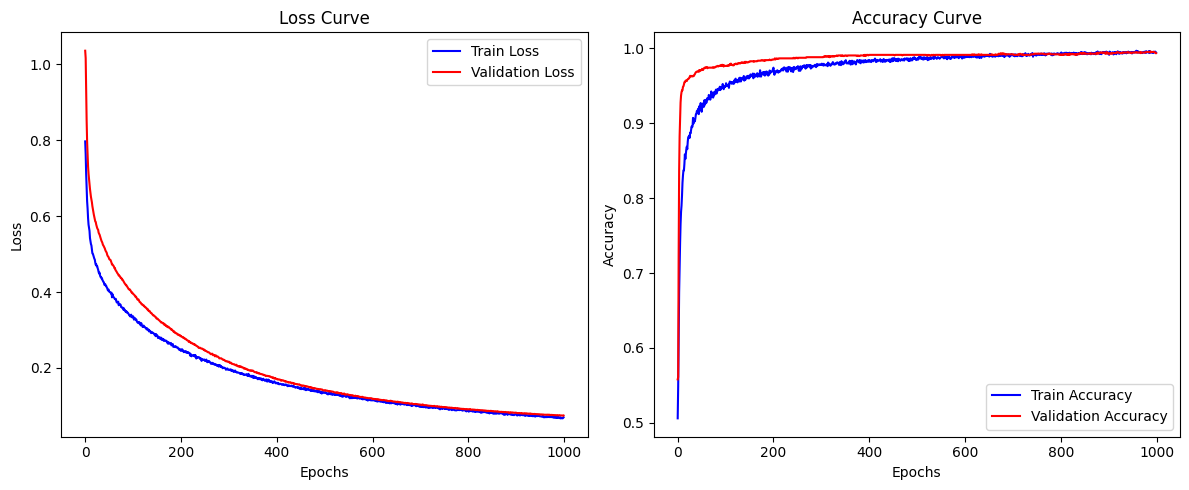

In [435]:
plot_training_history(train_loss_list, train_accuracy_list, validation_loss_list, validation_accuracy_list)

# Evaluate on the test set 

In [437]:
test_loss, test_accuracy, predicted_labels, true_labels = evaluate(model, X_test, y_test, loss_function)
print("Test Loss: ",  test_loss) 
print("Test Accuracy: ", test_accuracy * 100, "%")

Test Loss:  0.07930930703878403
Test Accuracy:  98.91219891219892 %


# Evaluation Metrics 
- Classification Report
- Confusion Matrix
- ROC Curve

In [438]:
def make_heat_map(confusion_matrix, title):
    plt.figure(figsize=(12, 5))
    sns.heatmap(confusion_matrix, fmt="d", annot=True, cmap="Blues", cbar=True)
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

def evaluation_metrics(true_labels, predicted_labels):
    predictions = (predicted_labels >= 0.5).astype(int)
    
    print("Classification Report:")
    print(classification_report(true_labels, predictions, digits= 4))

    cm = confusion_matrix(true_labels, predictions) 
    make_heat_map(cm, "Confusion Matrix")

    fpr, tpr, _ = roc_curve(true_labels, predicted_labels)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(12, 5))
    plt.plot(fpr, tpr, color="blue", label=f"ROC Curve")
    plt.plot([0, 1], [0, 1], color="red", linestyle="--", label="Random Guess Line")
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()
    print("AUC value: ", roc_auc)

Classification Report:
              precision    recall  f1-score   support

           0     0.9874    0.9929    0.9902       709
           1     0.9913    0.9844    0.9878       578

    accuracy                         0.9891      1287
   macro avg     0.9893    0.9887    0.9890      1287
weighted avg     0.9891    0.9891    0.9891      1287



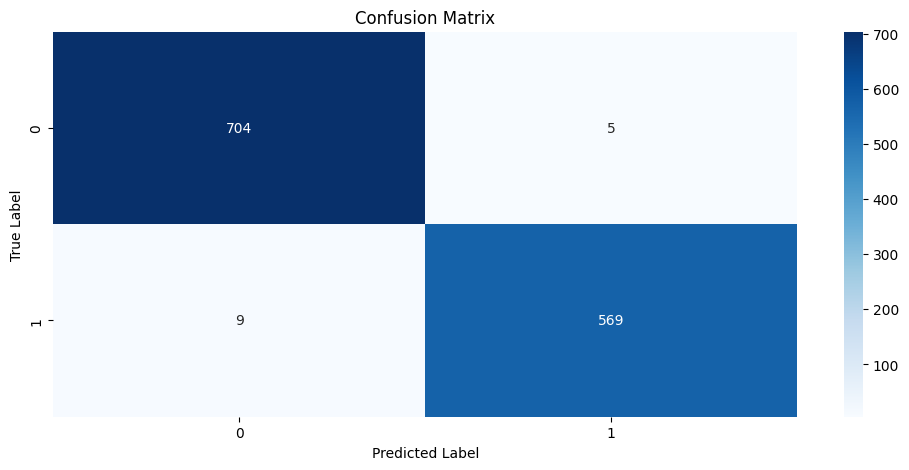

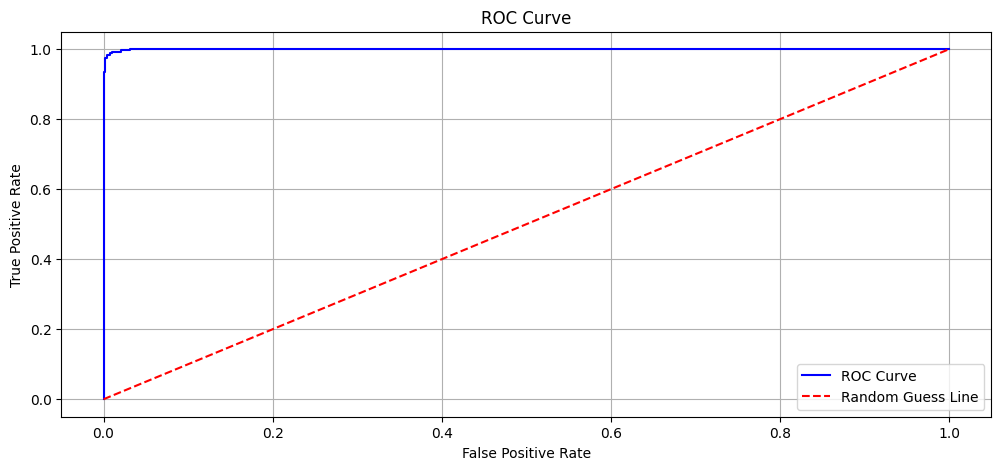

AUC value:  0.9996486107925291


In [439]:
evaluation_metrics(true_labels, predicted_labels)

# Where did it go wrong?  
Plot images that were missclassified by the model to see where it struggled to differentiate between the classes

In [455]:
def plot_misclassified_images(images, true_labels, predicted_labels):
    misclassified_indices = np.where(true_labels != predicted_labels)[0]
    num_misclassified = len(misclassified_indices)

    print(f"Number of misclassified images: {num_misclassified}")

    plt.figure(figsize=(15, 8))
    for i in range(num_misclassified):
        j = misclassified_indices[i]
        plt.subplot(3, (num_misclassified + 2) // 2, i + 1)  
        plt.imshow(images[j].squeeze(), cmap='gray')
        plt.title(f"True: {true_labels[j]} , Predicted: {predicted_labels[j]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Number of misclassified images: 14


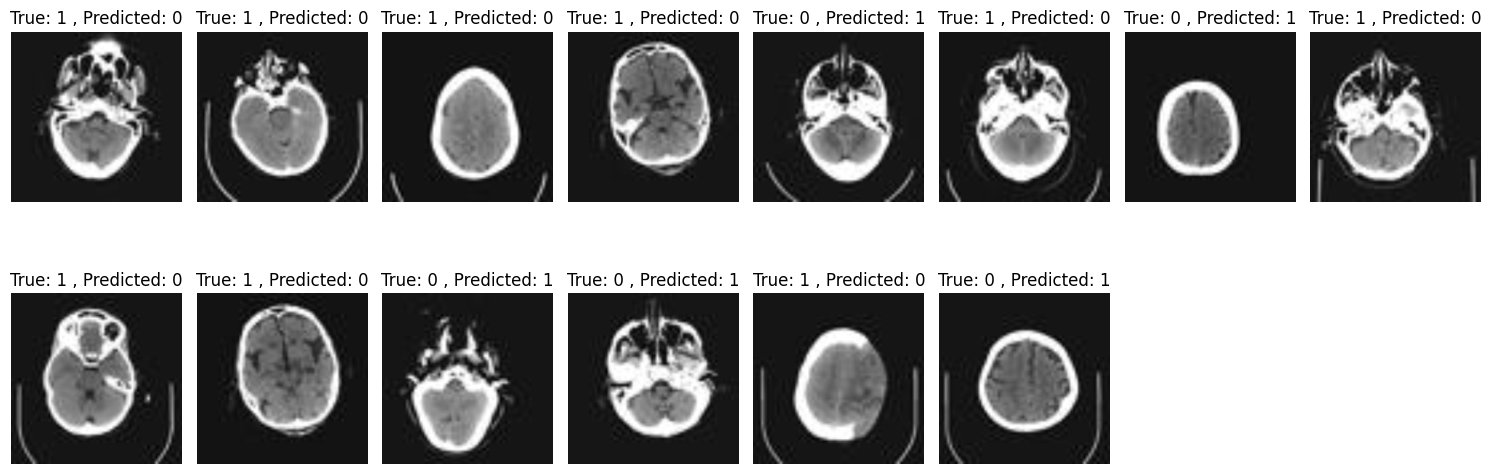

In [456]:
predictions = (predicted_labels >= 0.5).astype(int)
plot_misclassified_images(X_test, true_labels, predictions)

## Well done, Guardian Protector! 🎉

Your model has successfully safeguarded Earth Junior from Code Rot, ensuring few more years of peace and security. Humanity owes you a debt of gratitude—for your work to keep them safe! 🛡️